In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### TensorFlowの基本

In [2]:
g = tf.Graph()

# eval:個々のテンソルの評価。Tensorクラス
# run :演算の実行。Operationクラス
# tf.Session().run():テンソルと演算の両方を実行

with g.as_default():
    t1 = tf.constant(np.pi)
    t2 = tf.constant([1, 2, 3, 4])
    t3 = tf.constant([[1, 2], [3, 4]])

    r1 = tf.rank(t1)
    r2 = tf.rank(t2)
    r3 = tf.rank(t3)
    
    #print('Ranks:', r1, r2, r3)

    s1 = t1.get_shape()
    s2 = t2.get_shape()
    s3 = t3.get_shape()
    print('Shapes:', s1, s2, s3)

with tf.Session(graph=g) as sess:
    print('Ranks:', r1.eval(), r2.eval(), r3.eval())

Shapes: () (4,) (2, 2)


AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
g = tf.Graph()

# 計算グラフにノードを追加
with g.as_default():
    # テンソル
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.constant(3, name='c')
    # 演算
    z = 2 * (a-b) + c

In [ ]:
with tf.Session(graph=g) as sess:
    print('2*(a-b)+c => ', sess.run(z))

### プレースホルダ(基本)

In [97]:
# 階数が3、形状が3×4×5
tf.placeholder(dtype=tf.float32, shape=[2, 3, 4])

<tf.Tensor 'Placeholder_2:0' shape=(2, 3, 4) dtype=float32>

In [98]:
g = tf.Graph()
with g.as_default():
    tf_a = tf.placeholder(tf.int32, shape=[],name='tf_a')
    tf_b = tf.placeholder(tf.int32, shape=[],name='tf_b') 
    tf_c = tf.placeholder(tf.int32, shape=[],name='tf_c') 

    r1 = tf_a-tf_b
    r2 = 2*r1
    z  = r2 + tf_c

In [99]:
with tf.Session(graph=g) as sess:
    feed = {tf_a: 1, tf_b: 2, tf_c: 3}
    print('z:', sess.run(z, feed_dict=feed))

z: 1


### プレースホルダ(ミニバッチ)

In [100]:
g = tf.Graph()

with g.as_default():
    tf_x = tf.placeholder(tf.float32, shape=[None, 2],name='tf_x')
    x_mean = tf.reduce_mean(tf_x, axis=0, name='mean')

In [101]:
np.set_printoptions(precision=2)

with tf.Session(graph=g) as sess:
    # low以上high未満の一様乱数
    x1 = np.random.uniform(low=0, high=1, size=(5,2))
    print('Feeding data with shape', x1.shape)
    print('Result:', sess.run(x_mean, feed_dict={tf_x:x1}))
    
    x2 = np.random.uniform(low=0, high=1, size=(10,2))
    print('Feeding data with shape', x2.shape)
    print('Result:', sess.run(x_mean, feed_dict={tf_x:x2}))

Feeding data with shape (5, 2)
Result: [0.72 0.42]
Feeding data with shape (10, 2)
Result: [0.61 0.45]


### TensorFlowの変数

In [102]:
g1 = tf.Graph()

with g1.as_default():
    w = tf.Variable(np.array([[1, 2, 3, 4],
                              [5, 6, 7, 8]]), name='w')
    print(w)

<tf.Variable 'w:0' shape=(2, 4) dtype=int32_ref>


In [103]:
with tf.Session(graph=g1) as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(w))

[[1 2 3 4]
 [5 6 7 8]]


In [104]:
g2 = tf.Graph()

# w1は評価されるがw2は評価されない
with g2.as_default():
    w1 = tf.Variable(1, name='w1')
    init_op = tf.global_variables_initializer()
    w2 = tf.Variable(2, name='w2')

In [105]:
with tf.Session(graph=g2) as sess:
    sess.run(init_op)
    print('w1:', sess.run(w1))

w1: 1


In [106]:
with tf.Session(graph=g2) as sess:
    
    try:
        sess.run(init_op)
        print('w2:', sess.run(w2))
    except tf.errors.FailedPreconditionError as e:
        print(e)

Attempting to use uninitialized value w2
	 [[{{node _retval_w2_0_0}}]]


### 変数スコープ

In [107]:
g = tf.Graph()

with g.as_default():
    with tf.variable_scope('net_A'):
        with tf.variable_scope('layer-1'):
            w1 = tf.Variable(tf.random_normal(
                shape=(10,4)), name='weights')
        with tf.variable_scope('layer-2'):
            w2 = tf.Variable(tf.random_normal(
                shape=(20,10)), name='weights')
    with tf.variable_scope('net_B'):
        with tf.variable_scope('layer-1'):
            w3 = tf.Variable(tf.random_normal(
                shape=(10,4)), name='weights')

    print(w1)
    print(w2)
    print(w3)


<tf.Variable 'net_A/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>
<tf.Variable 'net_A/layer-2/weights:0' shape=(20, 10) dtype=float32_ref>
<tf.Variable 'net_B/layer-1/weights:0' shape=(10, 4) dtype=float32_ref>


### 変数の再利用

In [108]:
# 分類器
def build_classifier(data, labels, n_classes=2):
    data_shape = data.get_shape().as_list() # TensorshapeクラスのObject(テンソルの形状)
    
    weights = tf.get_variable(name='weights',shape=(data_shape[1], n_classes),dtype=tf.float32)
    bias = tf.get_variable(name='bias', initializer=tf.zeros(shape=n_classes))
    print(weights)
    print(bias)
    
    # tf.matmul:行列積
    # tf.add:総和
    logits = tf.add(tf.matmul(data, weights), bias, name='logits')
    print(logits)
    return logits, tf.nn.softmax(logits) # 総出力 & SoftMax(総出力)

# ジェネレータ
def build_generator(data, n_hidden):
    data_shape = data.get_shape().as_list()
    
    # tf.random_normal:正規分布の乱数生成
    # tf.zeros:0の配列生成
    w1 = tf.Variable(tf.random_normal(shape=(data_shape[1], n_hidden)),name='w1')
    b1 = tf.Variable(tf.zeros(shape=n_hidden), name='b1')
    hidden = tf.add(tf.matmul(data, w1), b1, name='hidden_pre-activation')
    hidden = tf.nn.relu(hidden, 'hidden_activation')
        
    w2 = tf.Variable(tf.random_normal(shape=(n_hidden, data_shape[1])),name='w2')
    b2 = tf.Variable(tf.zeros(shape=data_shape[1]),name='b2')
    output = tf.add(tf.matmul(hidden, w2), b2, name = 'output')
    
    return output, tf.nn.sigmoid(output)

# 計算グラフの構築
batch_size=64
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    with tf.variable_scope('classifier') as scope:
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
        scope.reuse_variables() # 変数の共有
        cls_out2 = build_classifier(data=gen_out1[1],labels=tf.zeros(shape=batch_size))
        
        init_op = tf.global_variables_initializer()

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [109]:
g = tf.Graph()

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    with tf.variable_scope('classifier'):
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
    with tf.variable_scope('classifier', reuse=True): # 変数の共有
        cls_out2 = build_classifier(data=gen_out1[1],labels=tf.zeros(shape=batch_size))
        
        init_op = tf.global_variables_initializer()

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier_1/logits:0", shape=(64, 2), dtype=float32)


### 回帰モデルの構築

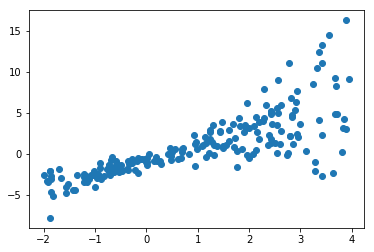

In [110]:
# 回帰用のランダムなデータセットの作成
def make_random_data():
    
    # np.random.uniform:low以上high未満の一様乱数
    x = np.random.uniform(low=-2, high=4, size=200)
    
    # y値
    y = []
    for t in x:
        # 正規分布(scale：標準偏差)
        r = np.random.normal(loc=0.0, scale=(0.5 + t*t/3), size=None)
        y.append(r)
    
    return  x, 1.726*x -0.84 + np.array(y)

x, y = make_random_data() 

plt.plot(x, y, 'o')
plt.show()

In [111]:
# 回帰用の計算グラフの作成

g = tf.Graph()

with g.as_default():
    tf.set_random_seed(123)
    
    # プレースホルダの定義(入力x, 入力y)
    tf_x = tf.placeholder(shape=(None), dtype=tf.float32, name='tf_x')
    tf_y = tf.placeholder(shape=(None), dtype=tf.float32,name='tf_y')
    
    # 変数
    weight = tf.Variable(tf.random_normal(shape=(1, 1), stddev=0.25),name='weight') # stddev:標準偏差
    bias = tf.Variable(0.0, name='bias')
    
    # モデルを構築
    y_hat = tf.add(weight * tf_x, bias, name='y_hat') # 総出力
    print(y_hat)
    
    # コストの計算
    cost = tf.reduce_mean(tf.square(tf_y - y_hat), name='cost') # tf.reduce_mean:数値の平均値
    print(cost)

    # モデルのトレーニング
    # GradientDescentOptimizer:勾配降下法のOptimizer
    optim = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optim.minimize(cost, name='train_op')

Tensor("y_hat:0", dtype=float32)
Tensor("cost:0", shape=(), dtype=float32)


In [112]:
# テストデータセットの分割
x_train, y_train = x[:100], y[:100]
x_test, y_test = x[100:], y[100:]

Epoch    0: 20.6086
Epoch   50: 13.2860
Epoch  100: 9.8373
Epoch  150: 8.1843
Epoch  200: 7.3675
Epoch  250: 6.9433
Epoch  300: 6.7063
Epoch  350: 6.5610
Epoch  400: 6.4625
Epoch  450: 6.3897


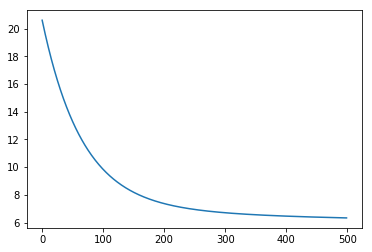

In [113]:
# モデルのトレーニング
n_epochs = 500
training_costs = []

with tf.Session(graph=g) as sess:
    # 変数の初期化
    sess.run(tf.global_variables_initializer())
    
    # 500エポックでモデルをトレーニング
    for e in range(n_epochs):
        c, _ = sess.run([cost, train_op], feed_dict={tf_x: x_train,tf_y: y_train})
        training_costs.append(c)
        
        # 50セットごとにprint
        if not e % 50:
            print('Epoch %4d: %.4f' % (e, c))

plt.plot(training_costs)

### トレーニングモデルを保存

In [114]:
# 計算グラフにsaverを追加
with g.as_default():
    saver = tf.train.Saver()

n_epochs = 500
training_costs = []

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(n_epochs):
        c, _ = sess.run(['cost:0', 'train_op'],feed_dict={'tf_x:0':x_train, 'tf_y:0':y_train})
        
        training_costs.append(c)
        if not e % 50:
            print('Epoch %4d: %.4f' % (e, c))
            
    saver.save(sess, './training_model/training_model')

Epoch    0: 20.6086
Epoch   50: 13.2860
Epoch  100: 9.8373
Epoch  150: 8.1843
Epoch  200: 7.3675
Epoch  250: 6.9433
Epoch  300: 6.7063
Epoch  350: 6.5610
Epoch  400: 6.4625
Epoch  450: 6.3897


INFO:tensorflow:Restoring parameters from ./training_model/training_model


INFO:tensorflow:Restoring parameters from ./training_model/training_model


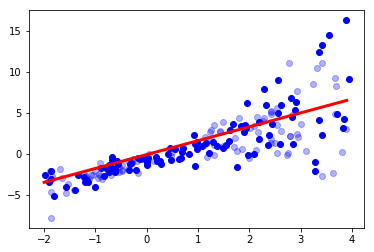

In [115]:
# 保存したファイルからモデルを復元

x_arr = np.arange(-2, 4, 0.1)
g2 = tf.Graph()

with tf.Session(graph=g2) as sess:
    new_saver = tf.train.import_meta_graph('./training_model/training_model.meta')
    new_saver.restore(sess, './training_model/training_model')
    # 予測結果をここでは走らせる
    y_arr = sess.run('y_hat:0', feed_dict={'tf_x:0':x_arr})

plt.figure()
plt.plot(x_train, y_train, 'bo')
plt.plot(x_test, y_test, 'bo', alpha=0.3)
plt.plot(x_arr, y_arr.T[:, 0], '-r', lw=3)
plt.show()

### テンソルを多次元配列として変換する

In [116]:
g = tf.Graph()

with g.as_default():
    arr = np.array([[1., 2., 3., 3.5],
                [4., 5., 6., 6.5],
                [7., 8., 9., 9.5]])
    
    # 定数の定義
    T1 = tf.constant(arr, name='T1')
    print(T1)
    
    # shapeを取得
    s = T1.get_shape()
    print('Shape of T1 is', s)
    
    # 変数を定義
    T2 = tf.Variable(tf.random_normal(shape=s))
    print(T2)
    T3 = tf.Variable(tf.random_normal(shape=(s.as_list()[0],))) # 行を取得(as_listメソッドでアクセス)
    print(T3)
    
    # reshape
    T4 = tf.reshape(T1, shape=[1, 1, -1], name='T4') # -1は可変サイズ
    print(T4)
    T5 = tf.reshape(T1, shape=[1, 3, -1], name='T5')
    print(T5)
    
    # 配列の転置
    T6 = tf.transpose(T5, perm=[2, 1, 0], name='T6')
    print(T6)
    T7 = tf.transpose(T5, perm=[0, 2, 1], name='T7')
    print(T7)
    
    # テンソルをサブテンソルのリストに分割
    t5_splt = tf.split(T5, num_or_size_splits=4, axis=2, name='T8')
    print(t5_splt)

Tensor("T1:0", shape=(3, 4), dtype=float64)
Shape of T1 is (3, 4)
<tf.Variable 'Variable:0' shape=(3, 4) dtype=float32_ref>
<tf.Variable 'Variable_1:0' shape=(3,) dtype=float32_ref>
Tensor("T4:0", shape=(1, 1, 12), dtype=float64)
Tensor("T5:0", shape=(1, 3, 4), dtype=float64)
Tensor("T6:0", shape=(4, 3, 1), dtype=float64)
Tensor("T7:0", shape=(1, 4, 3), dtype=float64)
[<tf.Tensor 'T8:0' shape=(1, 3, 1) dtype=float64>, <tf.Tensor 'T8:1' shape=(1, 3, 1) dtype=float64>, <tf.Tensor 'T8:2' shape=(1, 3, 1) dtype=float64>, <tf.Tensor 'T8:3' shape=(1, 3, 1) dtype=float64>]


In [117]:
with tf.Session(graph=g) as sess:
    print(sess.run(T4))
    print(sess.run(T5))
    print(sess.run(t5_splt))

[[[1.  2.  3.  3.5 4.  5.  6.  6.5 7.  8.  9.  9.5]]]
[[[1.  2.  3.  3.5]
  [4.  5.  6.  6.5]
  [7.  8.  9.  9.5]]]
[array([[[1.],
        [4.],
        [7.]]]), array([[[2.],
        [5.],
        [8.]]]), array([[[3.],
        [6.],
        [9.]]]), array([[[3.5],
        [6.5],
        [9.5]]])]


In [118]:
g = tf.Graph()

with g.as_default():
    t1 = tf.ones(shape=(5, 1), dtype=tf.float32, name='t1')
    t2 = tf.zeros(shape=(5, 1),dtype=tf.float32, name='t2')
    print(t1)
    print(t2)

    # テンソルの結合
    t3 = tf.concat([t1, t2], axis=0, name='t3') # 縦結合
    print(t3)
    t4 = tf.concat([t1, t2], axis=1, name='t4') # 横結合
    print(t4)

Tensor("t1:0", shape=(5, 1), dtype=float32)
Tensor("t2:0", shape=(5, 1), dtype=float32)
Tensor("t3:0", shape=(10, 1), dtype=float32)
Tensor("t4:0", shape=(5, 2), dtype=float32)


In [119]:
with tf.Session(graph=g) as sess:
    print(t3.eval())
    print(t4.eval())

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### 制御構文

In [137]:
# IF文
g = tf.Graph()

with g.as_default():
    tf_x = tf.placeholder(dtype=tf.float32, shape=None, name='tf_x')
    tf_y = tf.placeholder(dtype=tf.float32, shape=None, name='tf_y')
    res = tf.cond(tf_x < tf_y,
                 lambda: tf.add(tf_x, tf_y, name='result_add'),
                 lambda: tf.subtract(tf_x, tf_y, name='result_sub')
                 )
    print('Object: ', res)

with tf.Session(graph=g) as sess:
    x, y = 1.0, 2.0
    print('x < y: %s -> Result:' % (x < y), res.eval(feed_dict={'tf_x:0': x, 'tf_y:0': y}))
    x, y = 2.0, 1.0
    print('x < y: %s -> Result:' % (x < y), res.eval(feed_dict={'tf_x:0': x,'tf_y:0': y}))

Object:  Tensor("cond/Merge:0", dtype=float32)
result:  Tensor("case/cond/Merge:0", shape=(), dtype=int32)
x < y: True -> Result: 3.0
x < y: False -> Result: 1.0
x < y: False -> Result: 2


In [144]:
# CASE文
g = tf.Graph()

with g.as_default():
    f1 = lambda: tf.constant(1)
    f2 = lambda: tf.constant(2)
    
    # tf.less:各要素を比較する。a < b の結果をT/Fで返す。
    result = tf.case([(tf.less(x, y), f1)], default=f2)
    print('result: ', result)

with tf.Session(graph=g) as sess:
    print('Result: %s' % result.eval())

result:  Tensor("case/cond/Merge:0", shape=(), dtype=int32)
Result: 2


In [154]:
# ループ文
g = tf.Graph()

with g.as_default():
    i = tf.constant(0)
    
    c = lambda i: tf.less(i, 99)
    b = lambda i: tf.add(i, 1)
    
    # condがcの間、bodyの処理が繰り返される
    r = tf.while_loop(cond=c, body=b, loop_vars=[i])

with tf.Session(graph=g) as sess:
    print('Result: %s' % r.eval())

Result: 99


### TensorBoardによる可視化

In [161]:
batch_size = 64
g = tf.Graph()

# build_generator
# 

with g.as_default():
    tf_X = tf.placeholder(shape=(batch_size, 100), dtype=tf.float32,name='tf_X')
    
    # ジェネレータを構築
    with tf.variable_scope('generator'):
        gen_out1 = build_generator(data=tf_X, n_hidden=50)
    
    # 分類器を構築
    with tf.variable_scope('classifier') as scope:
        # tf_Xに対しての分類器
        cls_out1 = build_classifier(data=tf_X, labels=tf.ones(shape=batch_size))
        
        # 生成されたデータに対しての分類器
        scope.reuse_variables()
        cls_out2 = build_classifier(data=gen_out1[1], labels=tf.zeros(shape=batch_size))

<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits:0", shape=(64, 2), dtype=float32)
<tf.Variable 'classifier/weights:0' shape=(100, 2) dtype=float32_ref>
<tf.Variable 'classifier/bias:0' shape=(2,) dtype=float32_ref>
Tensor("classifier/logits_1:0", shape=(64, 2), dtype=float32)


In [162]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    file_writer=tf.summary.FileWriter(logdir='./logs/', graph=g)

In [ ]:
# TensorBoardの起動
# AnacondaNavigator
# Environment->Prompt
# cd JupyterDirectory
# python -m tensorboard.main --logdir=./logs/ --host=127.0.0.1